In [13]:
! pwd

/home/madilynpaul/notebooks/hoomdpolymers/p3ht_study/15mer/den_temp_sweep


In [1]:
import os

from cmeutils.structure import order_parameter
from fresnel import camera, pathtrace, light
from gixstapose.diffractometer import Diffractometer, get_angle
from gixstapose.draw_scene import get_scene
import gsd.hoomd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from planckton.utils.units import string_to_quantity, kelvin_from_reduced
from scipy.interpolate import RectBivariateSpline
import signac
import unyt as u
import json
import warnings
warnings.filterwarnings("ignore")

p = signac.get_project()

/home/madilynpaul/miniconda3/envs/esp_val/lib/python3.8/site-packages/foyer/forcefield.py:8: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename
/home/madilynpaul/miniconda3/envs/esp_val/lib/python3.8/site-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/madilynpaul/miniconda3/envs/esp_val/lib/python3.8/site-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https:

In [8]:
class phase_diagram:
    def __init__(self, project, a_max):
        self.project = project
        self.a_max = a_max
        
    def den_temp_phase(self,gsd_filename,CGgsd_filename,mapping_filename):
        """project: sigac project
        a_max: maximum angle in cluster criteria
        """
        #get reference data:
        for job in self.project:
            if job.doc.get("done"):
                break
        ref_energy = u.unyt_quantity(input_scalar=job.doc.ref_energy,input_units='kcal/mol')
        ref_mass = u.unyt_quantity(input_scalar=job.doc["ref_mass"],input_units="kg")
        ref_distance = u.unyt_quantity(input_scalar=job.doc["ref_distance"],input_units='Angstrom')
        r_max = float(6 * u.Angstrom / ref_distance)
        
        #set up dictionaries/lists:
        o_dict = {}
        orders = []
        job_strs = []
        Temp_K = []
        density = []
        keys = []
        for job in self.project:
            if job.doc.equilibrated == True:
                temp_K = int(kelvin_from_reduced(job.sp.kT,ref_energy))
                dens = job.sp.density
                key = (dens,temp_K)
                if key not in keys: 
                    gsdfile = job.fn(gsd_filename)
                    cg_file = job.fn(CGgsd_filename)
                    map_file = job.fn(mapping_filename)
                    if job.doc.get("order") is None:
                        with open(map_file) as f:
                            d = json.load(f)
                        keys_list = list(d.keys())
                        for i in keys_list:
                            mapping = np.stack(d[i])
                        order, _ = order_parameter(gsdfile, cg_file, mapping, r_max, self.a_max)
                        
                        order = np.mean(order)
                o_dict[key] = order
                orders.append(order)
                keys.append(key)
                Temp_K.append(temp_K)
                density.append(dens)
                job_strs.append(str(job))

        return density, Temp_K, orders, o_dict

    def epsilon_temp_pd(self,gsd_filename,CGgsd_filename,mapping_filename):
        #get reference data:
        for job in self.project:
            if job.doc.get("done"):
                break
        ref_energy = u.unyt_quantity(input_scalar=job.doc.ref_energy,input_units='kcal/mol')
        ref_mass = u.unyt_quantity(input_scalar=job.doc["ref_mass"],input_units="kg")
        ref_distance = u.unyt_quantity(input_scalar=job.doc["ref_distance"],input_units='Angstrom')
        r_max = float(6 * u.Angstrom / ref_distance)
        
        o_dict = {}
        orders = []
        job_strs = []
        Temp_K = []
        e_factor = []
        keys = []
        for job in self.project:
            if job.doc.equilibrated == True:
                temp_K = int(kelvin_from_reduced(job.sp.kT,ref_energy))
                ef = job.sp.e_factor
                key = (ef,temp_K)
                if key not in keys: 
                    gsdfile = job.fn(gsd_filename)
                    cg_file = job.fn(CGgsd_filename)
                    map_file = job.fn(mapping_filename)
                    if job.doc.get("order") is None:
                        with open(map_file) as f:
                            d = json.load(f)
                        keys_list = list(d.keys())
                        for i in keys_list:
                            mapping = np.stack(d[i])
                        order, _ = order_parameter(gsdfile, cg_file, mapping, r_max, self.a_max)
                        
                        order = np.mean(order)
                o_dict[key] = order
                orders.append(order)
                keys.append(key)
                Temp_K.append(temp_K)
                e_factor.append(ef)
                job_strs.append(str(job))

        x = np.array(ef)
        y = np.array(Temp_K)
        z = np.array(orders)
        
        ux = np.unique(x)
        uy = np.unique(y)
        uz = np.zeros((len(uy),len(ux)))
        
        # key = (ef, t_si)
        for i, xi in enumerate(ux):
            for j, yj in enumerate(uy):
                uz[j,i] = o_dict[(xi, yj)]
        
        f = RectBivariateSpline(uy,ux,uz,kx=2,ky=2)
        
        xs = np.linspace(0.2, 1.2, 15)
        ys = np.linspace(0, 700, 15)
        zs = f(ys, xs)
        
        zs[np.where(zs > 1)] = 1
        zs[np.where(zs < 0)] = 0
        
        plt.contourf(xs, ys, zs, 15, cmap="rainbow", vmax=1, vmin=0)
        
        cbar = plt.colorbar(ticks=np.linspace(0, 1, 5, endpoint=True))
        cbar.ax.set_title(r"$\psi$", fontsize=40, pad=20)
        
        # Show the positions of the sample points, just to have some reference
        plt.scatter(x, y, c="k", marker="x", s=100)
        plt.xlabel(r"epsilon ($\%$)",fontsize=20)
        plt.ylabel("Temperature (K)",fontsize=20)
        plt.xticks(np.linspace(0.2, 1.2, 6))
        fig = plt.gcf()
        fig.set_size_inches(12, 10)
        return fig

    def pd_fig(self,x,y,z,o_dict):
        x = np.array(x)
        y = np.array(y)
        z = np.array(z)
        
        ux = np.unique(x)
        uy = np.unique(y)
        uz = np.zeros((len(uy),len(ux)))
        
        # key = (ef, t_si)
        for i, xi in enumerate(ux):
            for j, yj in enumerate(uy):
                uz[j,i] = o_dict[(xi, yj)]
        
        f = RectBivariateSpline(uy,ux,uz,kx=2,ky=2)
        
        xs = np.linspace(0.2, 1.2, 15)
        ys = np.linspace(0, 700, 15)
        zs = f(ys, xs)
        
        zs[np.where(zs > 1)] = 1
        zs[np.where(zs < 0)] = 0
        
        plt.contourf(xs, ys, zs, 15, cmap="rainbow", vmax=1, vmin=0)
        
        cbar = plt.colorbar(ticks=np.linspace(0, 1, 5, endpoint=True))
        cbar.ax.set_title(r"$\psi$", fontsize=40, pad=20)
        
        # Show the positions of the sample points, just to have some reference
        plt.scatter(x, y, c="k", marker="x", s=100)
        plt.xlabel(r"Density ($\rho$)",fontsize=20)
        plt.ylabel("Temperature (K)",fontsize=20)
        plt.xticks(np.linspace(0.2, 1.2, 6))
        fig = plt.gcf()
        fig.set_size_inches(12, 10)

In [9]:
a = phase_diagram(project=p,a_max=10)
b = a.den_temp_phase(gsd_filename='cg_traj.gsd',CGgsd_filename="p3ht-cg.gsd",mapping_filename="p3ht-cg-mapping.json")

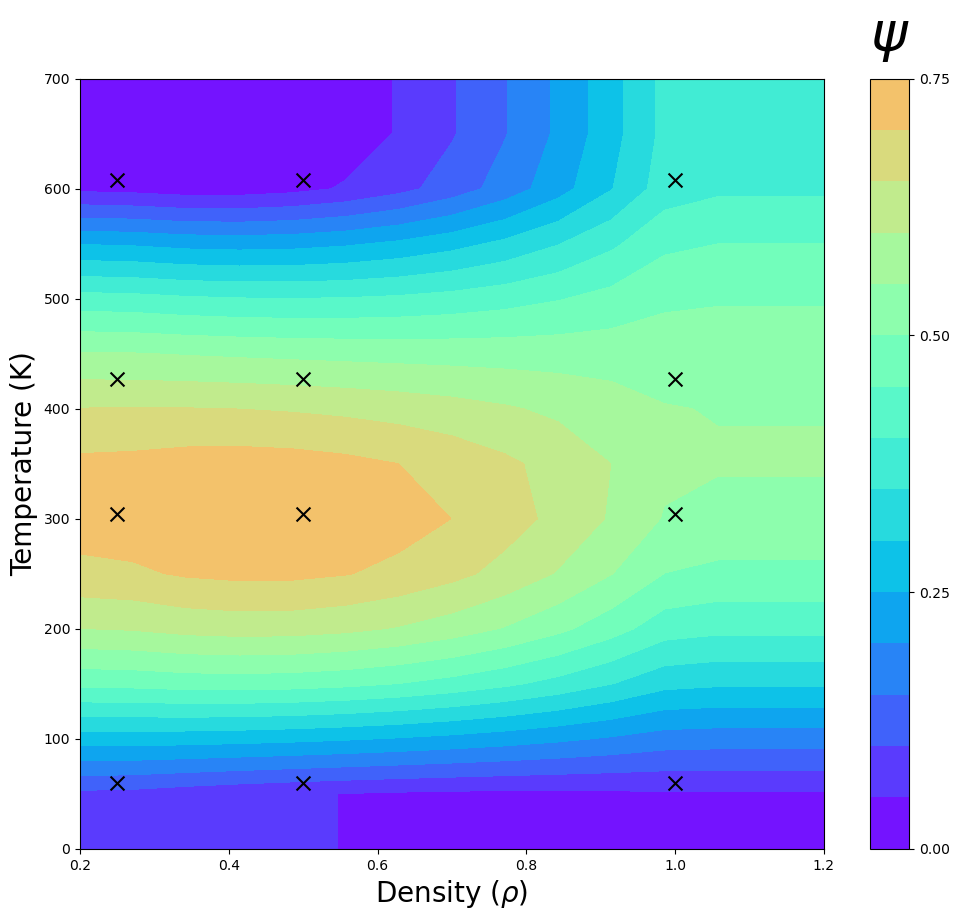

In [12]:
a.pd_fig(x=b[0],y=b[1],z=b[2],o_dict = b[3])